 В предыдущих юнитах мы рассмотрели отдельные модели для построения рекомендательных систем. Иногда эти модели используются вместе, такой способ построения рекомендательной системы называется гибридным.

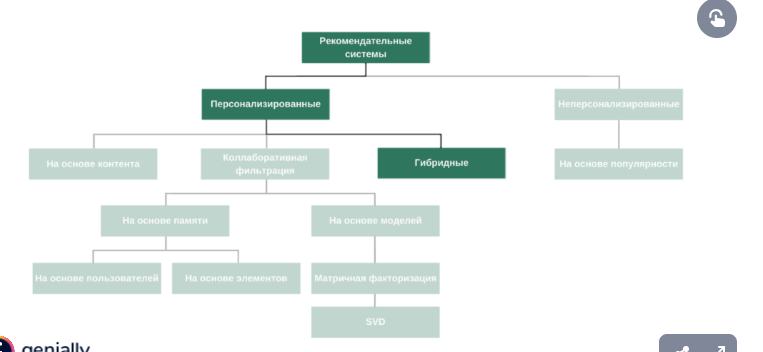

Гибридная РС — это особый тип рекомендательной системы, который представляет собой комбинацию из нескольких методов. Обычно это комбинация контентного подхода и коллаборативной фильтрации. Такое сочетание может помочь преодолеть недостатки, с которыми мы сталкиваемся при использовании этих методов по отдельности, а также в некоторых случаях может быть более эффективным.

Гибридные подходы к рекомендательным системам можно реализовать по-разному, например используя комбинацию из рекомендаций, полученных обеими системами, или используя взвешенную сумму предсказанных рейтингов.


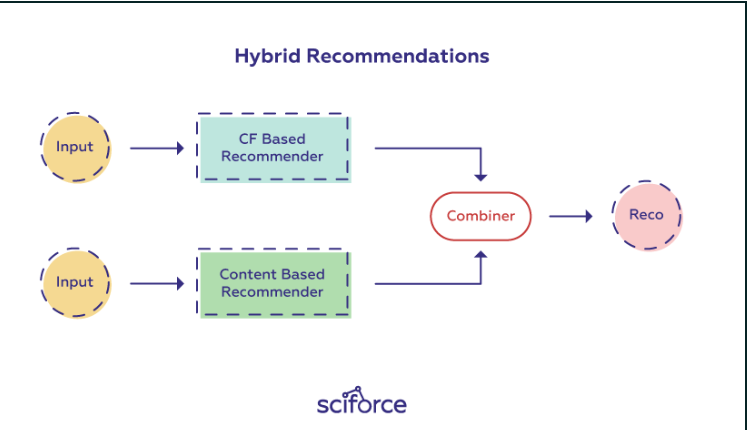

Давайте на практике рассмотрим, как создать рекомендательную систему с помощью гибридного подхода.

Разумеется, можно комбинировать различные подходы самостоятельно, однако для удобства уже реализован модуль LightFM — установим библиотеку через следующую команду:

In [ ]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.1/310.1 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.16-cp39-cp39-linux_x86_64.whl size=895274 sha256=52277f15e03d210bdf546d4a26b4192a1e040f2aa0ec2f8b2cf1220151a82371
  Stored in directory: /root/.cache/pip/wheels/d7/75/52/e42e5f9cd86d4902a352aff4dadde75ec041af713ffcf3ed05
Successfully built lightfm


Примечание. К сожалению, при локальном использовании этой библиотеки очень часто возникают ошибки. Если вы столкнулись с этим, рекомендуем использовать Google Colab.

Импортируем нужные нам функции из этой библиотеки. На этом этапе сразу же загрузим инструменты оценки модели:

In [ ]:
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k  

Работать мы будем с датасетом goodreads_book.

Goodreads — это сайт, на котором люди могут добавлять книги в каталоги, искать их, изучать аннотации и отзывы. Пользователи также могут создавать сообщества, в которых они рекомендуют друг другу различную литературу, ведут блоги и устраивают обсуждения

In [ ]:
import pandas as pd


In [ ]:
ratings = pd.read_csv('ratings.csv') #поставленные оценки
books = pd.read_csv('books.csv') #информация о книгах
tags = pd.read_csv('tags.csv') #информация о тегах
book_tags = pd.read_csv('book_tags.csv') #книги с тегами 

Сначала посмотрим на набор данных books: в этих данных есть обычный id книги, а есть id книги в системе Goodreads — этот id отображён в признаке goodreads_book_id. В других данных (book_tags) указан только id книги в системе Goodreads, поэтому нам необходимо добавить туда обычный id.

Добавьте в набор данных book_tags признак с обычным id книги, используя соответствие обычного id и id в системе Goodreads.

Какой обычный id у книги, которая имеет id 5 в системе Goodreads?

In [ ]:
books[:1]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...


In [ ]:
books[books['goodreads_book_id']==5]

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
17,18,5,5,2402163,376,043965548X,9.780440e+12,"J.K. Rowling, Mary GrandPré, Rufus Beck",1999.0,Harry Potter and the Prisoner of Azkaban,...,1832823,1969375,36099,6716,20413,166129,509447,1266670,https://images.gr-assets.com/books/1499277281m...,https://images.gr-assets.com/books/1499277281s...


In [ ]:
book_tags[:1]

,goodreads_book_id,tag_id,count
0,1,30574,167697


In [ ]:
book_tags[book_tags['goodreads_book_id']==5][:2]

,goodreads_book_id,tag_id,count
300,5,11557,40087
301,5,11305,39330


In [ ]:
dict_map = dict(zip(books.goodreads_book_id,books.book_id))
book_tags['id'] = book_tags.goodreads_book_id.apply(lambda x: dict_map[x])
 
book_tags[book_tags['goodreads_book_id']==5][:2]

,goodreads_book_id,tag_id,count,id
300,5,11557,40087,18
301,5,11305,39330,18


Далее нам необходимо оставить в наборе данных book_tags только те записи, теги для которых есть в этих tags.

Отфильтруйте данные таким образом, чтобы в наборе данных book_tags остались только те строки, в которых находятся теги, информация о которых есть в наборе данных tags.

Сколько объектов осталось?

In [ ]:
tags.tag_id.shape

(334,)

In [ ]:
book_tags = book_tags[book_tags.tag_id.isin(tags.tag_id)]
book_tags.shape

(300738, 4)

Отлично, мы подготовили информацию о тегах книг — это будет метаинформацией для построения рекомендательной системы. Теперь нам необходимо подготовить данные о взаимодействии пользователей и книг. Для этого нам понадобится файл ratings.

Оба набора данных (и про взаимодействия, и про метаинформацию) необходимо преобразовать в разрежённые матрицы. Это можно сделать с помощью специальной функции из модуля scipy:

In [ ]:
from scipy.sparse import csr_matrix

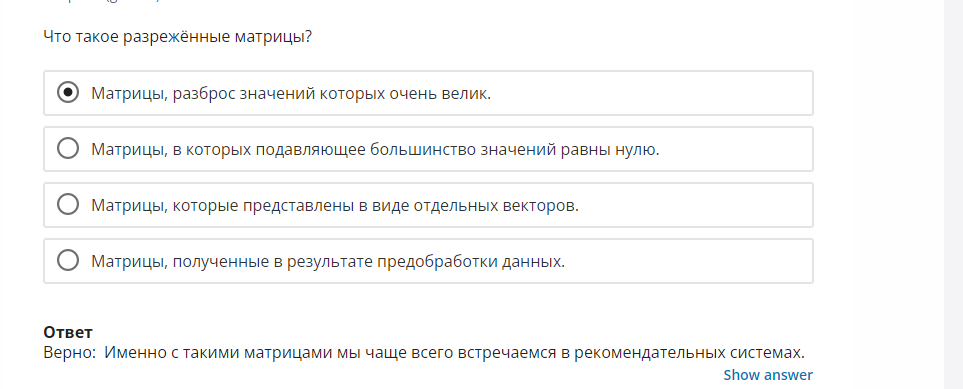

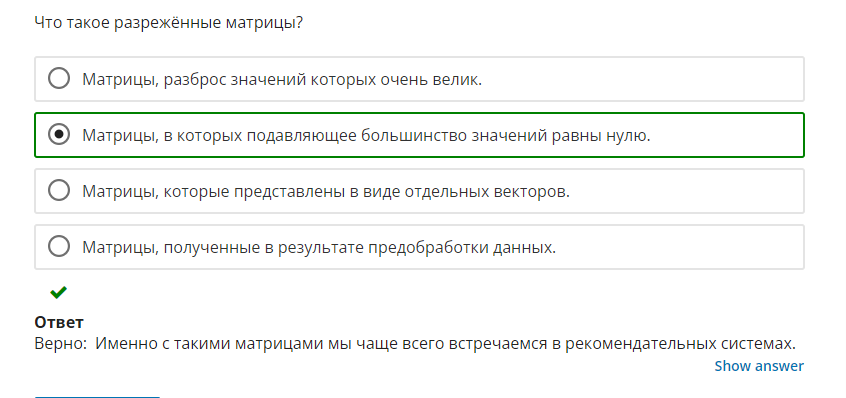

Нам важно преобразовать данные в специальный формат, в котором хранятся разрежённые матрицы: будем использовать формат Compressed Sparse Row (CSR), подразумевающий подсчёт кумулятивной суммы количества элементов в строке вместо индексов строк.

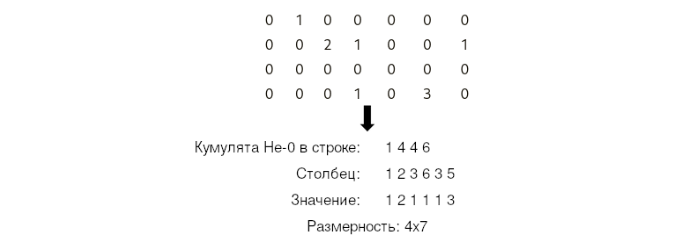

Здесь хранится информация о том, сколько суммарно ненулевых элементов в этой строке и выше, индексы столбцов с ненулевыми значениями, сами значения и размерность матрицы.

В первой строке обозначено, сколько накоплено ненулевых значений (в первой строке — суммарно 1, после второй строки — суммарно 4, после третьей строки — суммарно 4, после четвёртой строки — суммарно 6).

Во второй строке показано, в каком столбце находится ненулевое значение.

В третьей строке указаны сами значения.
Осуществляем преобразование следующим образом:

In [ ]:
ratings[:1]

,book_id,user_id,rating
0,1,314,5


In [ ]:
ratings_matrix = csr_matrix((ratings.rating,(ratings.user_id,ratings.book_id))) #передаём в качестве аргументов в функцию выставленный рейтинг
# (это будут значения матрицы), а также id пользователя и 
#id книги (это будут индексы для строк и столбцов матрицы)

Теперь нам необходимо составить матрицу с метаданными. В качестве индексов будут выступать id книги и id тега, и если у этой книги есть рассматриваемый тег, то на пересечении соответствующих строки и столбца будет выставлена единица.

In [ ]:
meta_matrix  = csr_matrix(([1]*len(book_tags),(book_tags.id,book_tags.tag_id))) 
meta_matrix

<10001x33269 sparse matrix of type '<class 'numpy.int64'>'
	with 300738 stored elements in Compressed Sparse Row format>

Давайте проверим, что всё получилось правильно.

Каково среднее арифметическое значений разрежённой матрицы с метаинформацией? Ответ округлите до трёх знаков после точки-разделителя.



In [ ]:
ratings_matrix.mean()

0.007086188900997592

Отлично, данные подготовлены, теперь настало время определить модель, которую мы будем использовать. Сделаем это следующим образом:

In [ ]:
model = LightFM(loss='warp', #определяем функцию потерь
                random_state=13, #фиксируем случайное разбиение
                learning_rate=0.05, #темп обучения
                no_components=100) #размерность вектора для представления данных в модели

В качестве функции потерь мы выбрали значение 'warp', хотя, разумеется, это не единственный вариант. В модуле LightFM представлены следующие функции потерь:

'logistic' — логистическая функция. Полезна в случаях, когда есть как положительные, так и отрицательные взаимодействия, например 1 и -1;

'bpr' — байесовский персонализированный рейтинг. Можно применять, когда присутствуют только положительные взаимодействия;

'warp' — парный взвешенный приблизительный ранг. Используется, если необходимо повысить качество именно в верхней части списка рекомендаций;
'warp-kos' — модификация warp.

In [ ]:
train,test = random_train_test_split(ratings_matrix, test_percentage=0.3, random_state=13)

Теперь обучим модель на наших данных о взаимодействии, также используя метаданные о книгах

In [ ]:
model = model.fit(train, item_features = meta_matrix)

Обратите внимание: из-за трудоёмкости вычислений обучение модели и оценка качества могут занимать вплоть до 15–20 минут (зависит от мощности компьютера). Не волнуйтесь, это нормальная ситуация.

Оцените качество полученной модели с помощью функции precision_at_k, передав в неё три аргумента: модель, тестовые данные и обозначение метаданных (item_features = meta_matrix).

Выведите среднее арифметическое и округлите его до двух знаков после точки-разделителя.

In [ ]:
prec_score = precision_at_k(
                     model,
                     test,
                     item_features = meta_matrix).mean() 
print(prec_score)

0.017568793


В рекомендательных системах метрики интерпретируются иначе, чем в задачах классификации. Показатели точности РС считаются хорошими, если они находятся в районе 0.1–0.3. Таким образом, результат получился хорошим: гибридная система действительно показала высокое качество.

Для предсказания рейтинга для нового пользователя можно воспользоваться методом predict():

In [ ]:
#scores = model.predict(<индекс интересующего пользователя>, np.arange(n_items),user_features=new_user_feature)

Итак, мы реализовали гибридную РС и оценили её качество. Какие преимущества и недостатки есть у этого подхода?

Img

Использование разных моделей позволяет компенсировать их недостатки и использовать преимущества каждой модели для составления рекомендаций.
Благодаря использованию сразу нескольких методов, такой подход позволяет получить более персонализированные и точные рекомендации.

Img

Такие модели обычно имеют высокую вычислительную сложность и из-за этого долго обучаются.
Для обучения таких моделей требуются большие объёмы данных и поступление новых данных для обновления рекомендаций.

В этом юните мы обсудили, что такое гибридная рекомендательная система, и познакомились с библиотекой LightFM, с помощью которой можно обучать подобные системы. В следующем юните вас ожидает последний в этом модуле подход к построению рекомендательных систем — искусственные нейронные сети.